In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from numpy import log
from random import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('task_3.csv')

In [3]:
df.head()

,event_timestamp,registration_timestamp,inapp_size
0,1611154038,1610971359,5
1,1611759898,1610972522,3
2,1611057594,1610974545,5
3,1611562555,1610976251,3
4,1611082290,1610976461,3


In [4]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit="s").dt.date
df['registration_timestamp'] = pd.to_datetime(df['registration_timestamp'], unit="s").dt.date

In [212]:
# df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
# # df['registration_timestamp'] = pd.to_datetime(df['registration_timestamp'])

In [5]:
df.dtypes

event_timestamp           object
registration_timestamp    object
inapp_size                 int64
dtype: object

In [6]:
df['registration_timestamp'].describe()

count          11577
unique            31
top       2021-01-01
freq             610
Name: registration_timestamp, dtype: object

In [7]:
df['event_timestamp'].describe()

count          11577
unique           118
top       2021-01-23
freq             381
Name: event_timestamp, dtype: object

In [8]:
df['date_since_reg'] = (df['event_timestamp'] - df['registration_timestamp']).dt.days+1

In [9]:
df.head(5)

,event_timestamp,registration_timestamp,inapp_size,date_since_reg
0,2021-01-20,2021-01-18,5,3
1,2021-01-27,2021-01-18,3,10
2,2021-01-19,2021-01-18,5,2
3,2021-01-25,2021-01-18,3,8
4,2021-01-19,2021-01-18,3,2


### Посчитаем выручку накопительным итогом. Надеюсь я правильно понял задание и нужно считать кумулятивную сумму в группировке по дням с начала регистрации (date_since_reg), а не в группировке по дате регистрации (registration_timestamp) и date_since_reg.

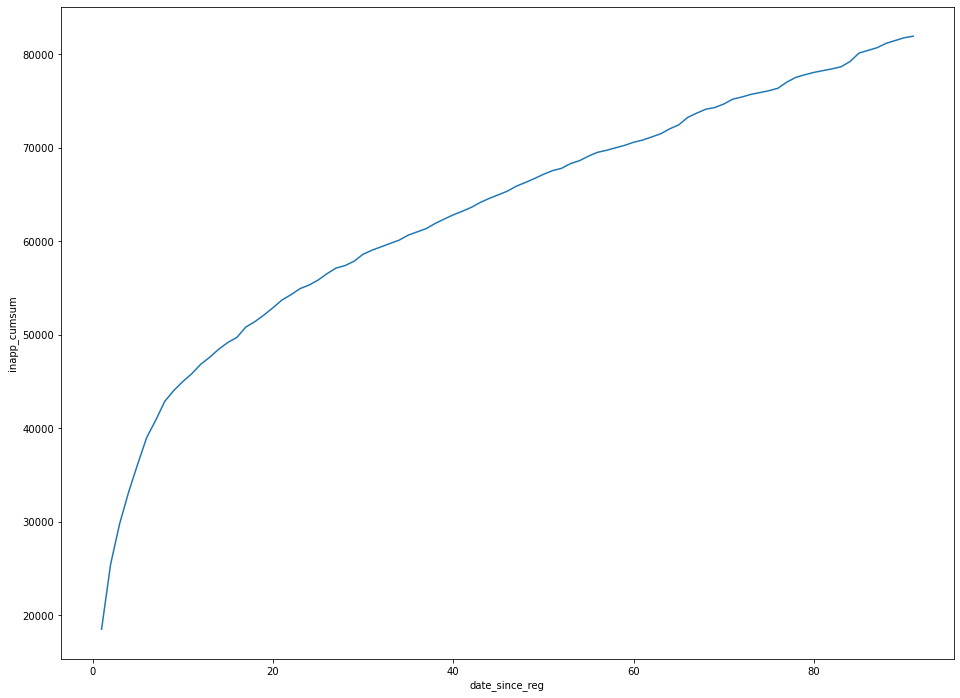

In [10]:
cumsum_revenue = (
    df
    .groupby(['date_since_reg'], as_index=False)['inapp_size'].sum()
#     .assign(inapp_cumsum = cumsum_revenue['inapp_size'].cumsum())
)
cumsum_revenue['inapp_cumsum'] = cumsum_revenue['inapp_size'].cumsum()
plt.figure(figsize=(16,12))
sns.lineplot(x='date_since_reg', y='inapp_cumsum', data=cumsum_revenue);

In [11]:
cumsum_revenue.head()

,date_since_reg,inapp_size,inapp_cumsum
0,1,18491,18491
1,2,6933,25424
2,3,4341,29765
3,4,3397,33162
4,5,2978,36140


### Прогноз накопительной суммы для дней дизни продукта с 90 по 180

**Для прогноза применим логарифмическую и степенную функции подгонки кривой с помощью библиотеки scipy.curve_fit() и выберем лучшую**

## Логарифмическая функция

In [12]:
X = cumsum_revenue['date_since_reg'].values 
Y = cumsum_revenue['inapp_cumsum'].values

In [13]:
# Задаем интервал прогнозных дней
t = np.arange(1, 181)

In [14]:
def logarithmic_function(t, a, b):
    return a*log(t) + b

In [15]:
def fit_curve(func, X, Y):
    
    popt = curve_fit(func, X, Y)
    X_fit = popt[0][0]
    Y_fit = popt[0][1]
    
    fit = []
    for i in t:
        fit.append(func(i, X_fit, Y_fit))
    return fit

In [16]:
log_fit = fit_curve(logarithmic_function, X, Y)

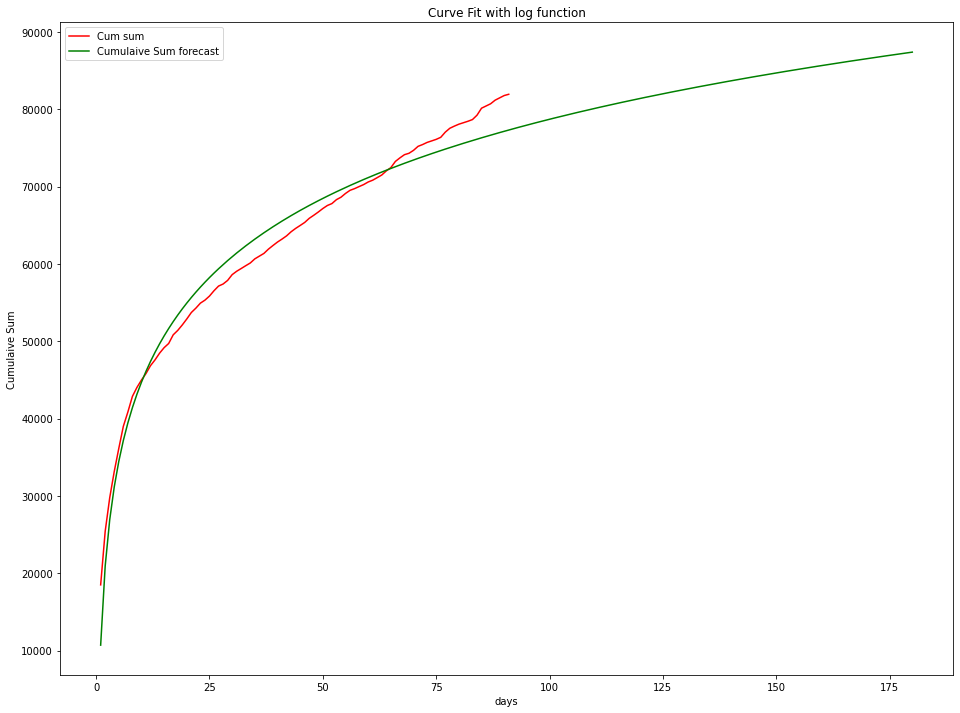

In [17]:
plt.figure(figsize=(16,12))
sns.lineplot(X,Y, color="r")
sns.lineplot(t, log_fit, color="g")
# plt.grid()
plt.xlabel("days")
plt.ylabel("Cumulaive Sum")
plt.title("Curve Fit with log function")
plt.legend(['Cum sum', 'Cumulaive Sum forecast'])
plt.show()

**Логарифмическая функция не лучшим образом прогнозирует в нашем случае**

## Степенная функция

In [18]:
# Задаем интервал прогнозных дней
t = np.arange(0, 181)

In [19]:
# Определеяем переменные, по которым будем строить модель
X = cumsum_revenue['date_since_reg'].values 
Y = cumsum_revenue['inapp_cumsum'].values

In [20]:
#  Степенная функция расчета: power_law: y = a*x^b
def power_law(t, X, Y):
    return X*np.power(t, Y)

In [246]:
# Прогноз значений
def fit_curve(func, X, Y):
    
    popt = curve_fit(func, X, Y)
    X_fit = popt[0][0]
    Y_fit = popt[0][1]
    
    fit = []
    for i in t:
        fit.append(func(i, X_fit, Y_fit))
    return fit

In [247]:
power_fit_0_180 = fit_curve(power_law, X, Y)

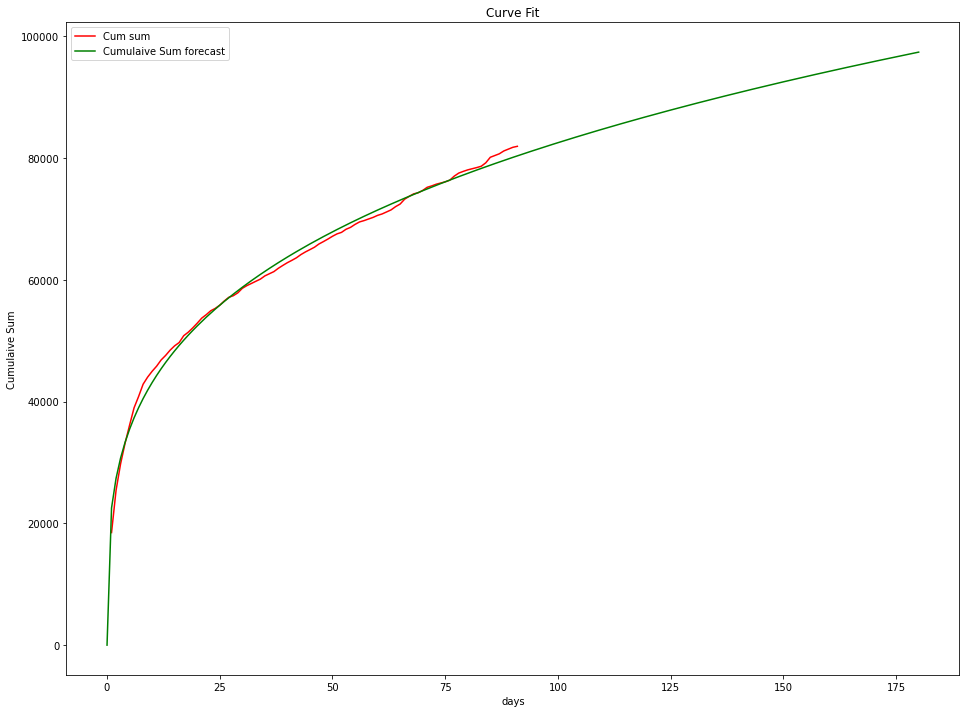

In [248]:
plt.figure(figsize=(16,12))
sns.lineplot(X,Y, color="r")
sns.lineplot(t, power_fit_0_180, color="g")
# plt.grid()
plt.xlabel("days")
plt.ylabel("Cumulaive Sum")
plt.title("Curve Fit")
plt.legend(['Cum sum', 'Cumulaive Sum forecast'])
plt.show()

**Степенная функция лучше прогнозирует кривую по нашим данным**

In [249]:
# Прогноз с 90 по 180 дни
t = np.arange(90, 181)
power_fit_90_180 = fit_curve(power_law, X, Y)

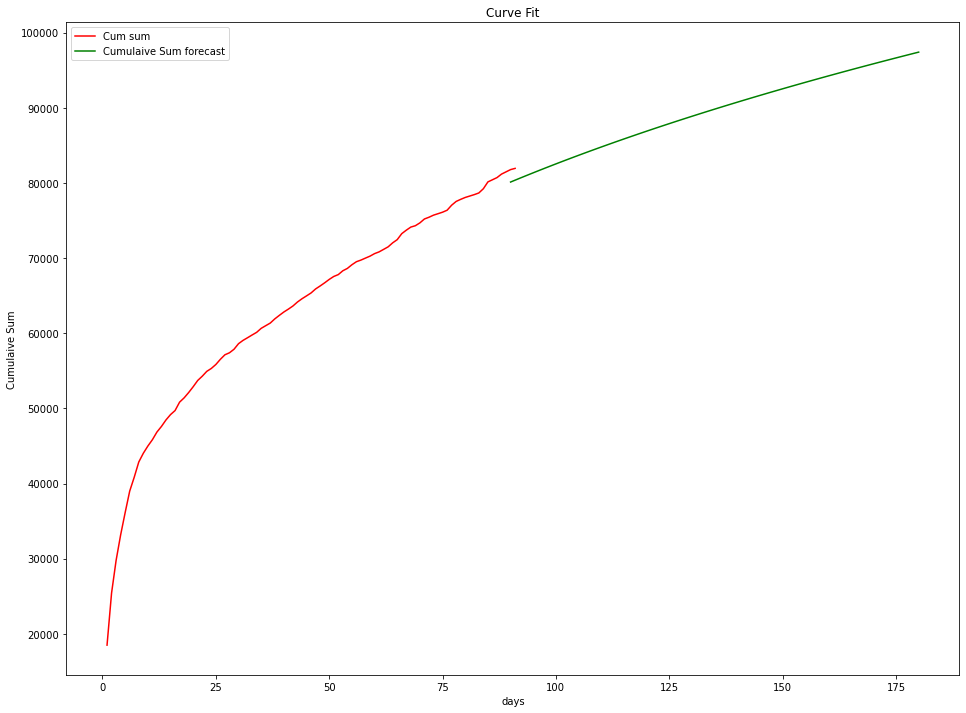

In [251]:
plt.figure(figsize=(16,12))
sns.lineplot(X,Y, color="r")
sns.lineplot(t, power_fit_90_180, color="g")
# plt.grid()
plt.xlabel("days")
plt.ylabel("Cumulaive Sum")
plt.title("Curve Fit")
plt.legend(['Cum sum', 'Cumulaive Sum forecast'])
plt.show()

**Также для прогнозирования можно использовать библиотеки для прогнозирования временных рядов ARIMA, SARIMA, Prophet.**